In [1]:
import asyncio
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt

from tqdm import tqdm
from web3 import Web3
from web3.eth import AsyncEth

In [2]:
TOPICS = [
    "0x8d685bd3f45d861c759ed7a46ea3d30eb5cc6ce9fe06c526931f94c963bca7d2",  # Provide
    "0x5b6b431d4476a211bb7d41c20d1aab9ae2321deee0d20be3d9fc9b1093fa6e3d",  # Withdraw
]
PEG_KEEPERS = {
    "USDC": "0x5B49b9adD1ecfe53E19cc2cFc8a33127cD6bA4C6",
    "USDT": "0xFF78468340EE322ed63C432BF74D817742b392Bf",
    "pyUSD": "0x68e31e1eDD641B13cAEAb1Ac1BE661B19CC021ca",
    "TUSD": "0x0B502e48E950095d93E8b739aD146C72b4f6C820",
}
CEILINGS = {
    "USDC": 25_000_000 * 10 ** 18,
    "USDT": 25_000_000 * 10 ** 18,
    "pyUSD": 15_000_000 * 10 ** 18,
    "TUSD": 10_000_000 * 10 ** 18,
}
START = 19962279
END = 0  # 0 for latest block

COLORS={
    "USDC": "#3E73C4",
    "USDT": "#6BAC95",
    "pyUSD": "#2F6ED9",
    "TUSD": "#2E59F6",
}

In [4]:
web3 = Web3(
    provider=Web3.AsyncHTTPProvider(
        f"http://localhost:8545",
        {"verify_ssl": False}
    ),
    modules={"eth": (AsyncEth,)},
    middlewares=[],
)

In [5]:
async def fetch_logs():
    global END
    if END == 0:
        END = await web3.eth.block_number
    print(f"Querying through {END - START} blocks")
    entries = []
    for topic in TOPICS:
        entries.extend(await web3.eth.get_logs(
            {
                "fromBlock": START - 2000,
                "toBlock": END,
                "address": list(PEG_KEEPERS.values()),
                "topics": [topic],
            }
        ))
    entries.sort(key=lambda log: log["blockNumber"])  # Action_delay allows us to do this
    return entries

def get_amounts(entries):
    amounts = {pk: [] for pk in PEG_KEEPERS.values()}
    for log in entries:
        pk_address = str(log["address"])
        amounts[pk_address].append((
            log["blockNumber"],
            int(log["data"].hex(), base=16) * (-1 if log['topics'][0].hex() == TOPICS[1] else 1),  # -1 for Withdraw
        ))
    return amounts

def retrieve_address(data):
    if isinstance(data, str):
        return Web3.to_checksum_address("0x" + data[-40:])
    else:
        return retrieve_address(data.hex())

amounts_entries = await fetch_logs()
print(f"Fetched {len(amounts_entries)} logs")
amounts = get_amounts(amounts_entries)

Querying through 121187 blocks
Fetched 54 logs


In [6]:
async def fetch_timestamps(block_nums):
    blocks = [web3.eth.get_block(block_id) for block_id in block_nums]
    return [(await block)["timestamp"] for block in blocks]

block_nums = list(sorted(set([amount[0] for pk_amounts in amounts.values() for amount in pk_amounts])))
block_timestamps = await fetch_timestamps(block_nums)
block_dates = mdates.date2num([dt.datetime.fromtimestamp(ts) for ts in block_timestamps])

In [7]:
cum_sums = []
for addr in PEG_KEEPERS.values():
    cum_sums.append([])
    cum_sum = 0
    cur_iter = iter(amounts[addr] + [(np.inf, 0)])
    next_amount = next(cur_iter)
    for block_num in block_nums:
        if block_num == next_amount[0]:
            cum_sum += next_amount[1]
            next_amount = next(cur_iter)
        cum_sums[-1].append(cum_sum / 10 ** 18)

cum_sums = np.array(cum_sums)

In [8]:
def plot(cum_values, ax=plt, title="Peg Keepers' debt distribution", ylabel="USD"):
    ax.stackplot(
        block_dates, cum_values,
        labels=PEG_KEEPERS.keys(),
        colors=[COLORS[coin] for coin in PEG_KEEPERS.keys()],
        step='post',
    )
    if ax != plt:
        ax.set(ylabel=ylabel)
    else:
        plt.title(title)
        plt.ylabel(ylabel)
        plt.legend()
        ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

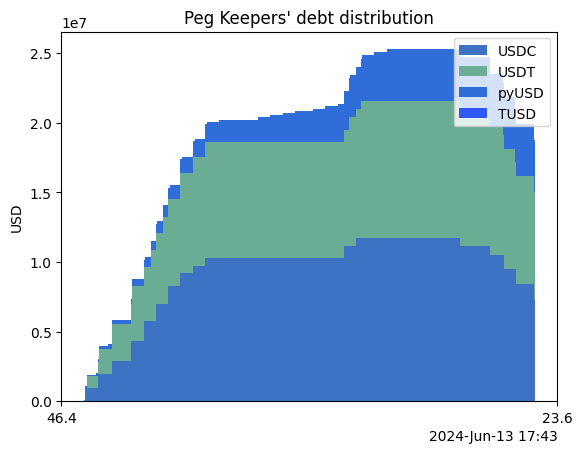

In [9]:
plot(cum_sums)

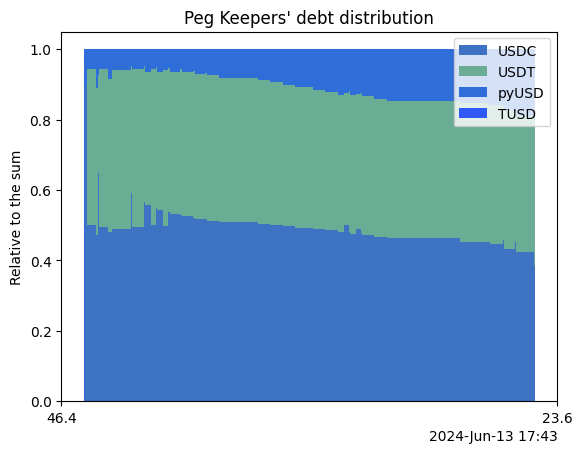

In [10]:
sums = np.sum(cum_sums, axis=0)
sums[sums == 0] = 1
cum_sums_relative = cum_sums / sums
plot(cum_sums_relative, ylabel="Relative to the sum")

In [11]:
period = (20080100, 20080600)

aggregator = web3.eth.contract(
    address="0x18672b1b0c623a30089A280Ed9256379fb0E4E62",
    abi=[{"stateMutability":"view","type":"function","name":"price","inputs":[],"outputs":[{"name":"","type":"uint256"}]},],
)

regulator = web3.eth.contract(
    address="0x36a04CAffc681fa179558B2Aaba30395CDdd855f",
    abi=[{"stateMutability":"view","type":"function","name":"provide_allowed","inputs":[{"name":"_pk","type":"address"}],"outputs":[{"name":"","type":"uint256"}]},],
)

pool_abi = [
    {"stateMutability":"view","type":"function","name":"get_p","inputs":[],"outputs":[{"name":"","type":"uint256"}]},
    {"stateMutability":"view","type":"function","name":"price_oracle","inputs":[],"outputs":[{"name":"","type":"uint256"}]},
]
ng_pool_abi = [
    {"stateMutability":"view","type":"function","name":"get_p","inputs":[{"name":"i","type":"uint256"}],"outputs":[{"name":"","type":"uint256"}]},
    {"stateMutability":"view","type":"function","name":"price_oracle","inputs":[{"name":"i","type":"uint256"}],"outputs":[{"name":"","type":"uint256"}]},
]
pools = {
    "USDT": web3.eth.contract(address="0x390f3595bCa2Df7d23783dFd126427CCeb997BF4", abi=pool_abi),
    "USDC": web3.eth.contract(address="0x4DEcE678ceceb27446b35C672dC7d61F30bAD69E", abi=pool_abi),
    "pyUSD": web3.eth.contract(address="0x625E92624Bc2D88619ACCc1788365A69767f6200", abi=ng_pool_abi),
    "TUSD": web3.eth.contract(address="0x34D655069F4cAc1547E4C8cA284FfFF5ad4A8db0", abi=pool_abi),
}

agg_prices = [aggregator.functions.price().call(block_identifier=block) for block in range(*period)]
spot_prices = {
    coin: [pool.functions.get_p().call(block_identifier=block) for block in range(*period)]
    for coin, pool in pools.items() if coin != "pyUSD"
}
spot_prices["pyUSD"] = [pools["pyUSD"].functions.get_p(0).call(block_identifier=block) for block in range(*period)]

oracle_prices = {
    coin: [pool.functions.price_oracle().call(block_identifier=block) for block in range(*period)]
    for coin, pool in pools.items() if coin != "pyUSD"
}
oracle_prices["pyUSD"] = [pools["pyUSD"].functions.price_oracle(0).call(block_identifier=block) for block in range(*period)]

allowed_to_provide = {
    coin: [regulator.functions.provide_allowed(pk).call(block_identifier=block) for block in range(*period)]
    for coin, pk in PEG_KEEPERS.items()
}

agg_prices = [await p for p in agg_prices]
spot_prices = {coin: [await p for p in ps] for coin, ps in spot_prices.items()}
oracle_prices = {coin: [await p for p in ps] for coin, ps in oracle_prices.items()}

allowed_to_provide = {coin: [await a for a in ap] for coin, ap in allowed_to_provide.items()}

In [96]:
PRICE_DEVIATION = 500000000000000

def plot_pk(coin):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('block')
    ax1.set_ylabel('price')
    ax1.plot(range(*period), agg_prices, color="darkolivegreen", label="aggregator_price")
    ax1.plot(range(*period), spot_prices[coin], color="palegreen", label="spot_price")
    ax1.plot(range(*period), oracle_prices[coin], color="yellowgreen", label="oracle_price")
    ax1.tick_params(axis='y', labelcolor=COLORS[coin])

    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

    color = 'navy'
    ax2.set_ylabel('allowed', color=color)  # we already handled the x-label with ax1
    block = period[0]
    while block < period[1]:
        start = block
    
        # Allowed to provide
        while block < period[1] and allowed_to_provide[coin][block - period[0]] > 0 :
            block += 1
        if block > start:
            ax2.plot(
                range(start, block),
                [allowed_to_provide[coin][b - period[0]] for b in range(start, block)],
                color="slategrey", label="Allowed",
            )
            continue

        # Aggregator price
        while block < period[1] and agg_prices[block - period[0]] < 10 ** 18:
            block += 1
        if block > start:
            ax2.plot(
                range(start, block),
                [allowed_to_provide[coin][b - period[0]] for b in range(start, block)],
                color="midnightblue", label="Aggregator Price < 1",
            )
            continue 
        
        # Price deviation
        while block < period[1] and abs(spot_prices[coin][block - period[0]] - oracle_prices[coin][block - period[0]]) >= PRICE_DEVIATION:
            block += 1
        if block > start:
            ax2.plot(
                range(start, block),
                [allowed_to_provide[coin][b - period[0]] for b in range(start, block)],
                color="blue", label="Price deviation too big",
            )
            continue
        
        # Worst price
        while block < period[1] and max(*[oracle_prices[c][block - period[0]] for c in oracle_prices.keys()]) < (oracle_prices[coin][block - period[0]] - 3 * 10 ** (18 - 4)):
            block += 1
        if block > start:
            ax2.plot(
                range(start, block),
                [allowed_to_provide[coin][b - period[0]] for b in range(start, block)],
                color="rebeccapurple", label="Worst price among peg_keepers",
            )
            continue
        
        print(block)
        block += 1  # Unknown

    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.legend()
    plt.show()

20080217
20080218
20080219
20080220
20080222
20080223
20080224
20080225


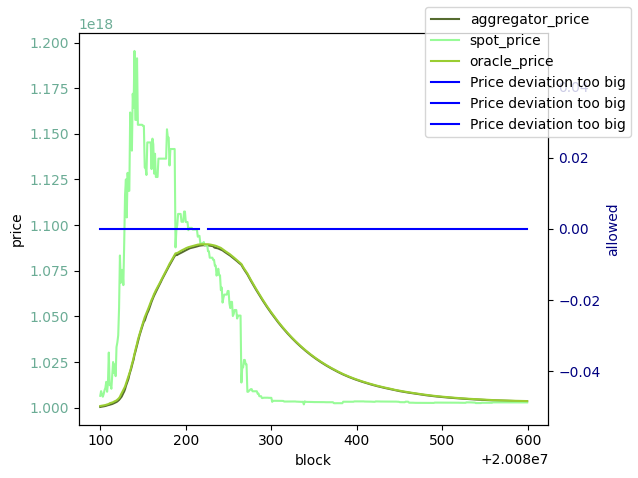

In [97]:
plot_pk("USDT")

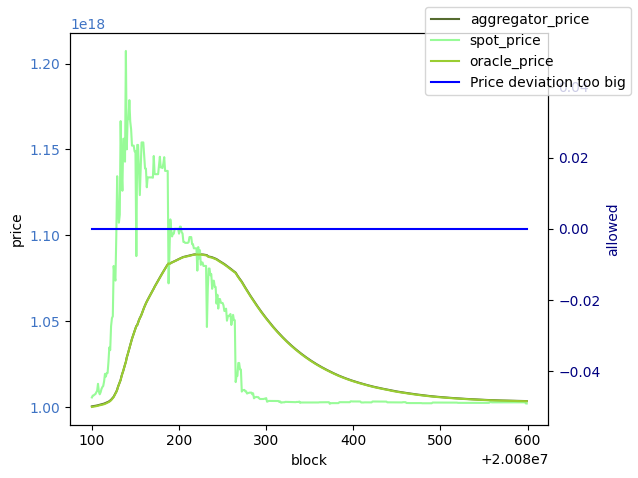

In [98]:
plot_pk("USDC")

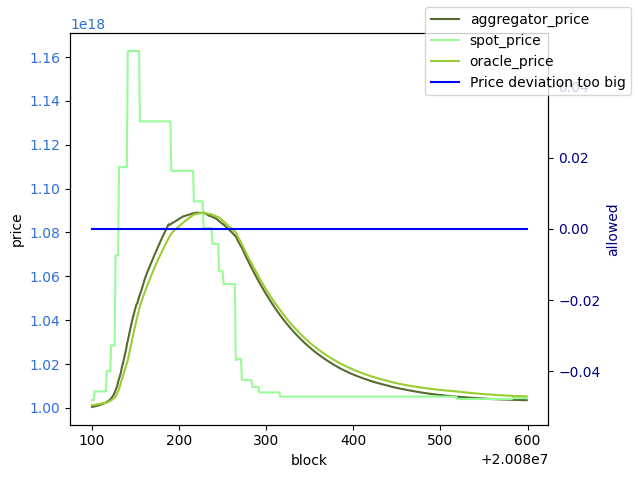

In [99]:
plot_pk("pyUSD")

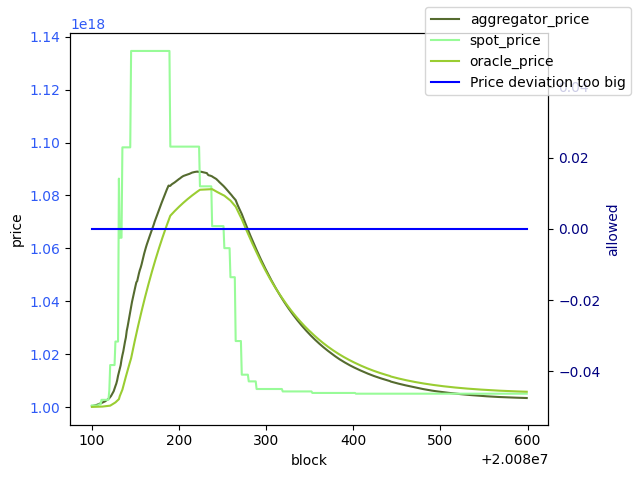

In [100]:
plot_pk("TUSD")

## Simulator

In [119]:
class Curve:

    """
    Python model of Curve pool math.
    """

    def __init__(self, A, D, n, p=None, tokens=None, fee=10 ** 7, admin_fee=0):
        """
        A: Amplification coefficient
        D: Total deposit size
        n: number of currencies
        p: target prices
        """
        self.A = A  # actually A * n ** (n - 1) because it's an invariant
        self.n = n
        self.fee = fee
        self.admin_fee = admin_fee
        if p:
            self.p = p
        else:
            self.p = [10 ** 18] * n
        if isinstance(D, list):
            self.x = D
        else:
            self.x = [D // n * 10 ** 18 // _p for _p in self.p]
        self.tokens = tokens

    def xp(self):
        return [x * p // 10 ** 18 for x, p in zip(self.x, self.p)]

    def D(self):
        """
        D invariant calculation in non-overflowing integer operations
        iteratively

        A * sum(x_i) * n**n + D = A * D * n**n + D**(n+1) / (n**n * prod(x_i))

        Converging solution:
        D[j+1] = (A * n**n * sum(x_i) - D[j]**(n+1) / (n**n prod(x_i))) / (A * n**n - 1)
        """
        Dprev = 0
        xp = self.xp()
        S = sum(xp)
        D = S
        Ann = self.A * self.n
        while abs(D - Dprev) > 1:
            D_P = D
            for x in xp:
                D_P = D_P * D // (self.n * x)
            Dprev = D
            D = (Ann * S + D_P * self.n) * D // ((Ann - 1) * D + (self.n + 1) * D_P)

        return D

    def y(self, i, j, x):
        """
        Calculate x[j] if one makes x[i] = x

        Done by solving quadratic equation iteratively.
        x_1**2 + x1 * (sum' - (A*n**n - 1) * D / (A * n**n)) = D ** (n+1)/(n ** (2 * n) * prod' * A)
        x_1**2 + b*x_1 = c

        x_1 = (x_1**2 + c) / (2*x_1 + b)
        """
        D = self.D()
        xx = self.xp()
        xx[i] = x  # x is quantity of underlying asset brought to 1e18 precision
        xx = [xx[k] for k in range(self.n) if k != j]
        Ann = self.A * self.n
        c = D
        for y in xx:
            c = c * D // (y * self.n)
        c = c * D // (self.n * Ann)
        b = sum(xx) + D // Ann - D
        y_prev = 0
        y = D
        while abs(y - y_prev) > 1:
            y_prev = y
            y = (y ** 2 + c) // (2 * y + b)
        return y  # the result is in underlying units too

    def y_D(self, i, _D):
        """
        Calculate x[j] if one makes x[i] = x

        Done by solving quadratic equation iteratively.
        x_1**2 + x1 * (sum' - (A*n**n - 1) * D / (A * n**n)) = D ** (n+1)/(n ** (2 * n) * prod' * A)
        x_1**2 + b*x_1 = c

        x_1 = (x_1**2 + c) / (2*x_1 + b)
        """
        xx = self.xp()
        xx = [xx[k] for k in range(self.n) if k != i]
        S = sum(xx)
        Ann = self.A * self.n
        c = _D
        for y in xx:
            c = c * _D // (y * self.n)
        c = c * _D // (self.n * Ann)
        b = S + _D // Ann
        y_prev = 0
        y = _D
        while abs(y - y_prev) > 1:
            y_prev = y
            y = (y ** 2 + c) // (2 * y + b - _D)
        return y  # the result is in underlying units too

    def get_p(self):
        ANN = self.A * 2
        D = self.D()
        Dr = D / 4
        xp = self.xp()
        for i in range(2):
            Dr = Dr * D // xp[i]
        return 10**18 * (ANN * xp[0] + Dr * xp[0] / xp[1]) / (ANN * xp[0] + Dr)

    def dy(self, i, j, dx):
        # dx and dy are in underlying units
        xp = self.xp()
        return xp[j] - self.y(i, j, xp[i] + dx)

    def exchange(self, i, j, dx):
        xp = self.xp()
        x = xp[i] + dx
        y = self.y(i, j, x)
        dy = xp[j] - y
        fee = dy * self.fee // 10 ** 10
        assert dy > 0
        self.x[i] = x * 10 ** 18 // self.p[i]
        self.x[j] = (y + fee) * 10 ** 18 // self.p[j]
        return dy - fee

    def add_liquidity(self, amounts, update_values=False):
        _fee = self.fee * self.n // (4 * (self.n - 1))

        old_balances = self.x
        D0 = self.D()

        new_balances = old_balances
        for i in range(self.n):
            new_balances[i] += amounts[i]
        self.x = new_balances
        D1 = self.D()
        assert D1 > D0

        fees = [0] * self.n
        if self.tokens > 0:
            real_balances = [0] * 3
            for i in range(self.n):
                ideal_balance = D1 * old_balances[i] // D0
                difference = abs(ideal_balance - new_balances[i])
                fees[i] = _fee * difference // 10 ** 10
                real_balances[i] = new_balances[i] - (fees[i] * self.admin_fee // 10 ** 10)
                new_balances[i] -= fees[i]
            self.x = new_balances
            D2 = self.D()
            mint_amount = self.tokens * (D2 - D0) // D0

            self.x = real_balances
        else:
            self.x = new_balances
            mint_amount = D1  # Take the dust if there was any

        if not update_values:
            self.x = old_balances
        else:
            self.tokens += mint_amount

        return mint_amount

    def remove_liquidity_imbalance(self, amounts, update_values=False):
        _fee = self.fee * self.n // (4 * (self.n - 1))

        old_balances = self.x
        new_balances = self.x[:]
        D0 = self.D()
        for i in range(self.n):
            new_balances[i] -= amounts[i]
        self.x = new_balances
        D1 = self.D()
        self.x = old_balances
        fees = [0] * self.n
        real_balances = [0] * self.n
        for i in range(self.n):
            ideal_balance = D1 * old_balances[i] // D0
            difference = abs(ideal_balance - new_balances[i])
            fees[i] = _fee * difference // 10 ** 10
            real_balances[i] = new_balances[i] - (fees[i] * self.admin_fee // 10 ** 10)
            new_balances[i] -= fees[i]
        self.x = new_balances
        D2 = self.D()

        token_amount = (D0 - D2) * self.tokens // D0

        self.x = real_balances
        if not update_values:
            self.x = old_balances
        else:
            self.tokens -= token_amount

        return token_amount

    def calc_withdraw_one_coin(self, token_amount, i):
        xp = self.xp()
        if self.fee:
            fee = self.fee - self.fee * xp[i] // sum(xp) + 5 * 10 ** 5
        else:
            fee = 0

        D0 = self.D()
        D1 = D0 - token_amount * D0 // self.tokens
        dy = xp[i] - self.y_D(i, D1)

        return dy - dy * fee // 10 ** 10

    def get_virtual_price(self):
        return self.D() * 10 ** 18 // self.tokens

## Sandwich

In [105]:
import boa
import requests_cache

boa.env.fork("http://localhost:8545")
ETHERSCAN_API_KEY = os.environ["ETHERSCAN_TOKEN"]

boa.explorer.SESSION = requests_cache.CachedSession('etherscan_cache', allowable_codes=[200], filter_fn=lambda response: int(response.json().get("status", 0)) == 1)

crvUSD = boa.from_etherscan("0xf939E0A03FB07F59A73314E73794Be0E57ac1b4E", name="crvUSD", api_key=ETHERSCAN_API_KEY)


In [33]:
regulator = boa.load_partial("../curve-stablecoin/contracts/stabilizer/PegKeeperRegulator.vy").at("0x36a04CAffc681fa179558B2Aaba30395CDdd855f")

In [106]:
coins = {
    "USDT": boa.from_etherscan(pool.coins(0), name="Coin", api_key=ETHERSCAN_API_KEY),
    "crvUSD": crvUSD,
}
coin = "USDT"
pool = boa.from_etherscan(pools[coin].address, name="Pool", api_key=ETHERSCAN_API_KEY)
pk = boa.from_etherscan(PEG_KEEPERS[coin], name="PegKeeper", api_key=ETHERSCAN_API_KEY)

assert pool.coins(1) == "0xf939E0A03FB07F59A73314E73794Be0E57ac1b4E"
coins = {
    "USDT": boa.from_etherscan(pool.coins(0), name="Coin", api_key=ETHERSCAN_API_KEY),
    "crvUSD": crvUSD,
}
coin = coins["USDT"]  # boa.from_etherscan(pool.coins(0), name="Coin", api_key=ETHERSCAN_API_KEY)

In [149]:
boa.env.fork("http://localhost:8545", block_identifier=20080140)
HOLDERS = {
    "USDT": "0xF977814e90dA44bFA03b6295A0616a897441aceC",
    "crvUSD": "0xA920De414eA4Ab66b97dA1bFE9e6EcA7d4219635",
}
p_diff = pool.get_p() - pool.price_oracle()
print(f"{(p_diff) / 10 ** 18:.6f}")
i = 1 if p_diff > 0 else 0
decimals = 18 if i == 1 else coin.decimals()
with boa.env.prank(HOLDERS["crvUSD" if i == 1 else "USDT"]):
    crvUSD.approve(pool, 2 ** 256 - 1)
    coin.approve(pool, 2 ** 256 - 1)

    dx, dy = 0, 0
    # initial step
    print(pool.get_balances())
    print(pool.get_p(), pool.price_oracle())
    dx += 529000000000000000000000
    dy += pool.exchange(i, 1 - i, dx, 1)
    print(f"i = {i}")
    print(pool.get_balances())
    print(pool.get_p(), pool.price_oracle())

    flash_coin = 1_000 * 10 ** decimals
    while regulator.provide_allowed(pk) == 0 and dx < 2_000_000 * 10 ** decimals:
        dx += flash_coin
        dy += pool.exchange(i, 1 - i, flash_coin, 1)
        p_diff = pool.get_p() - pool.price_oracle()
#         print(f"{(p_diff) / 10 ** 18:.6f}")
        if abs(p_diff) < PRICE_DEVIATION:
            print(dx, dy, p_diff)
            boa.env.time_travel(blocks=1)
            break
    if dx >= 1_000_000 * 10 ** decimals:
        print("could not find good price")
    received = pk.update()
    returned = pool.exchange(1 - i, i, dy, 1)
    print(f"{(returned - dx) / 10 ** decimals:.2f} delta from exchange, total diff {(returned - dx + received / 10 ** (18 - decimals)) / 10 ** decimals:.2f}")

0.166074
[9268409876841, 338951323949459031222922]
1195405106779539752 1029331396042326688
i = 1
[8698995836794, 867951323949459031222922]
1029791161640352007 1029331396042326688
530000000000000000000000 570415221534 390659453793574
36727.91 delta from exchange, total diff 39495.69


## Unlucky approximation

In [ ]:
from copy import deepcopy

A = 500
D = 2 * 10_000_000 * 10 ** 18
fee = 10 ** 7

curve = Curve(A, D, 2, fee=fee, admin_fee=0)

step = 100 * 10 ** 18
p, share, needed = [], [], []
for i in range(D // step // 2):
    p.append(curve.get_p())
    share.append(curve.x[0] / curve.x[1])
    cc = deepcopy(curve)
    needed.append(0)
    while (cc.get_p() - 10 ** 18) > 10 ** 12:
        needed[-1] += step
        cc.exchange(0, 1, step)
    curve.exchange(0, 1, step)

plt.plot(p, share)
plt.xlabel("Price")
plt.ylabel("Share")
plt.show()

In [ ]:
plt.plot(p, needed)
plt.xlabel("Price")
plt.ylabel("Needed dx to get 1")
plt.show()

In [132]:
import numpy as np
shares = np.array(share)
prices = np.array(p)

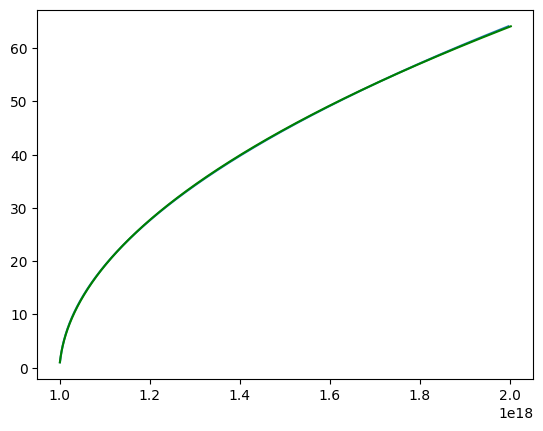

In [142]:
sh = np.poly1d(np.polyfit(shares,prices, deg=2))
plt.plot(prices, shares)
plt.plot(sh(shares), shares,'g-')
plt.show()

In [145]:
print(sh)

           2
2.311e+14 x + 8.436e+14 x + 9.988e+17


## Flashloan + scipy

In [184]:
import boa
import requests_cache
import os

boa.env.fork("http://localhost:8545")
ETHERSCAN_API_KEY = os.environ["ETHERSCAN_TOKEN"]

boa.explorer.SESSION = requests_cache.CachedSession('etherscan_cache', allowable_codes=[200], filter_fn=lambda response: int(response.json().get("status", 0)) == 1)

%load_ext boa.ipython

The boa.ipython extension is already loaded. To reload it, use:
  %reload_ext boa.ipython


In [218]:
%%vyper PegKeeperCaller
# pragma version 0.3.10
# pragma evm-version cancun

interface ERC20:
    def approve(_to: address, _value: uint256): nonpayable
    def transfer(_to: address, _value: uint256) -> bool: nonpayable
    def transferFrom(_from: address, _to: address, _value: uint256) -> bool: nonpayable
    def balanceOf(_owner: address) -> uint256: view
    def decimals() -> uint256: view

interface StableSwap:
    def get_p(i: uint256=0) -> uint256: view
    def price_oracle(i: uint256=0) -> uint256: view
    def get_balances() -> uint256[2]: view
    def exchange(i: int128, j: int128, _dx: uint256, _min_dy: uint256, _receiver: address = msg.sender) -> uint256: nonpayable
    def A_precise() -> uint256: view
    def fee() -> uint256: view
    def coins(i: uint256) -> ERC20: view

interface Regulator:
    def price_deviation() -> uint256: view

interface PegKeeper:
    def pool() -> StableSwap: view
    def IS_INVERSE() -> bool: view
    def update(_receiver: address = msg.sender) -> uint256: nonpayable

interface Morpho:
    def flashLoan(token: address, assets: uint256, data: Bytes[256]):nonpayable

struct Params:
    balances: uint256[2]
    decimals: uint256[2]
    p_o: uint256
    cur_p: uint256
    A: uint256
    fee: uint256
    is_inverse: bool

struct SandwichParams:
    amount: uint256
    i: int128
    pk: PegKeeper
    pool: StableSwap
    coin: ERC20
    receiver: address

REGULATOR: immutable(Regulator)
MORPHO: immutable(Morpho)

sandwich_params: transient(SandwichParams)

@external
def __init__(_regulator: Regulator, _morpho: Morpho, _pools: StableSwap[4]):
    REGULATOR = _regulator
    MORPHO = _morpho

    for pool in _pools:
        for i in range(2):
            pool.coins(i).approve(pool.address, max_value(uint256))


@view
@external
def get_params(pk: PegKeeper, _ng: bool) -> Params:
    pool: StableSwap = pk.pool()
    cur_p: uint256 = 0
    p_o: uint256 = 0
    if _ng:
        cur_p = pool.get_p(0)
        p_o = pool.price_oracle(0)
    else:
        cur_p = pool.get_p()
        p_o = pool.price_oracle()
    return Params({
        balances: pool.get_balances(),
        decimals: [pool.coins(0).decimals(), pool.coins(1).decimals()],
        p_o: p_o,
        cur_p: cur_p,
        A: pool.A_precise(),
        fee: pool.fee(),
        is_inverse: pk.IS_INVERSE()
    })


@external
def call(pk: PegKeeper, amount: uint256, i: int128, _receiver: address=msg.sender):
    if amount > 0:
        pool: StableSwap = pk.pool()
        coin: ERC20 = pool.coins(convert(i, uint256))
        self.sandwich_params = SandwichParams({
            amount: amount,
            i: i,
            pk: pk,
            pool: pool,
            coin: coin,
            receiver: _receiver,
        })
        MORPHO.flashLoan(coin.address, amount, b"")
        coin.transfer(_receiver, coin.balanceOf(self))
        return

    pk.update(_receiver)


@external
def onMorphoFlashLoan(assets: uint256, data: Bytes[256]):
    sp: SandwichParams = self.sandwich_params
    dy: uint256 = sp.pool.exchange(sp.i, 1-sp.i, sp.amount, 0)

    sp.pk.update(sp.receiver)

    sp.pool.exchange(1-sp.i, sp.i, dy, 0)

    sp.coin.approve(msg.sender, assets)


@external
def approve(_pool: StableSwap):
    _pool.coins(0).approve(_pool.address, max_value(uint256))
    _pool.coins(1).approve(_pool.address, max_value(uint256))


StateAccessViolation: Cannot make modifying calls from a constant function, use `is_static_call=True` to perform this action
  contract "PegKeeperCaller:68", function "get_params", line 68:14 
       67     success: bool = False
  ---> 68     success = raw_call(
  ----------------------^
       69         pool.address, method_id("get_p()"),


In [197]:
from copy import deepcopy

PRECISION = 10 ** 18
FEE_DENOMINATOR = 10 ** 10
A_PRECISION = 100
ADMIN_FEE = 5000000000

class Curve:
    def __init__(self, params):
        self.balances = params[0]
        self.rate_multipliers = [10 ** (18 - params[1][i]) for i in range(2)]
        self.p_o = params[2]
        self.initial_p = params[3]
        self.A = params[4]
        self.fee = params[5]
        self.is_inverse = params[6]
    
    def exchange(self, i, j, _dx):
        rates = self.rate_multipliers
        old_balances = deepcopy(self.balances)
        xp = self._xp_mem(rates, old_balances)

        x = xp[i] + _dx * rates[i] // PRECISION

        amp = self.A
        D = self.get_D(xp, amp)
        y = self.get_y(i, j, x, xp, amp, D)

        dy = xp[j] - y - 1  # -1 just in case there were some rounding errors
        dy_fee = dy * self.fee // FEE_DENOMINATOR

        # Convert all to real units
        dy = (dy - dy_fee) * PRECISION // rates[j]

        # xp is not used anymore, so we reuse it for price calc
        xp[i] = x
        xp[j] = y

        dy_admin_fee = dy_fee * ADMIN_FEE // FEE_DENOMINATOR
        dy_admin_fee = dy_admin_fee * PRECISION // rates[j]

        # Change balances exactly in same way as we change actual ERC20 coin amounts
        self.balances[i] = old_balances[i] + _dx
        # When rounding errors happen, we undercharge admin fee in favor of LP
        self.balances[j] = old_balances[j] - dy - dy_admin_fee

        return dy
    
    def _xp_mem(self, _rates, _balances):
        return [_rates[i] * _balances[i] // PRECISION for i in range(2)]
    
    def get_D(self, _xp, _amp):
        S = sum(_xp)
        if S == 0:
            return 0

        D = S
        Ann = _amp * 2
        for i in range(255):
            D_P = D * D // _xp[0] * D // _xp[1] // 4
            Dprev = D
            D = (Ann * S // A_PRECISION + D_P * 2) * D // ((Ann - A_PRECISION) * D // A_PRECISION + 3 * D_P)
            # Equality with the precision of 1
            if D > Dprev:
                if D - Dprev <= 1:
                    return D
            else:
                if Dprev - D <= 1:
                    return D
        # convergence typically occurs in 4 rounds or less, this should be unreachable!
        # if it does happen the pool is borked and LPs can withdraw via `remove_liquidity`
        raise
    
    def get_y(self, i, j, x, xp, _amp, _D):
        amp = _amp
        D = _D
        if _D == 0:
            amp = self.A
            D = self.get_D(xp, amp)
        S_ = 0
        _x = 0
        y_prev = 0
        c = D
        Ann = amp * 2

        for _i in range(2):
            if _i == i:
                _x = x
            elif _i != j:
                _x = xp[_i]
            else:
                continue
            S_ += _x
            c = c * D // (_x * 2)

        c = c * D * A_PRECISION // (Ann * 2)
        b: uint256 = S_ + D * A_PRECISION // Ann  # - D
        y: uint256 = D

        for _i in range(255):
            y_prev = y
            y = (y*y + c) // (2 * y + b - D)
            # Equality with the precision of 1
            if y > y_prev:
                if y - y_prev <= 1:
                    return y
            else:
                if y_prev - y <= 1:
                    return y
        raise

    def _get_p(self, xp, amp, D):
        # dx_0 / dx_1 only, however can have any number of coins in pool
        ANN = amp * 2
        Dr = D // 4
        for i in range(2):
            Dr = Dr * D // xp[i]
        return 10**18 * (ANN * xp[0] // A_PRECISION + Dr * xp[0] // xp[1]) // (ANN * xp[0] // A_PRECISION + Dr)


    def get_p(self):
        amp = self.A
        xp = self._xp_mem(self.rate_multipliers, self.balances)
        D = self.get_D(xp, amp)
        return self._get_p(xp, amp, D)

In [198]:
pools = {
    "USDT": "0x390f3595bCa2Df7d23783dFd126427CCeb997BF4",
    "USDC": "0x4DEcE678ceceb27446b35C672dC7d61F30bAD69E",
    "pyUSD": "0x625E92624Bc2D88619ACCc1788365A69767f6200",
    "TUSD": "0x34D655069F4cAc1547E4C8cA284FfFF5ad4A8db0",
}
PEG_KEEPERS = {
    "USDC": "0x5B49b9adD1ecfe53E19cc2cFc8a33127cD6bA4C6",
    "USDT": "0xFF78468340EE322ed63C432BF74D817742b392Bf",
    "pyUSD": "0x68e31e1eDD641B13cAEAb1Ac1BE661B19CC021ca",
    "TUSD": "0x0B502e48E950095d93E8b739aD146C72b4f6C820",
}

boa.env.fork("http://localhost:8545", block_identifier=20080140)
caller = PegKeeperCaller.deploy("0x36a04CAffc681fa179558B2Aaba30395CDdd855f", "0xBBBBBbbBBb9cC5e90e3b3Af64bdAF62C37EEFFCb", list(pools.values()))

COIN = "USDC"
pk = PEG_KEEPERS[COIN]
pool = boa.from_etherscan(pools[COIN], name="Pool", api_key=ETHERSCAN_API_KEY)
coins = [
    boa.from_etherscan(pool.coins(0), name="Coin", api_key=ETHERSCAN_API_KEY),
    boa.from_etherscan(pool.coins(1), name="Coin", api_key=ETHERSCAN_API_KEY),
    pool,
]
params = caller.get_params(pk)
curve = Curve(params)

In [199]:
params

([10582585775723, 444669977934298245703906],
 [6, 18],
 1028768151008859857,
 1150023559250999015,
 50000,
 1000000,
 False)

In [200]:
import numpy as np
from scipy.optimize import minimize_scalar
from copy import deepcopy

def optimization_fun(x, log=False):
    sim = deepcopy(curve)
    i = 0 if x < 0 else 1
    if x != 0:
        amount = abs(int(x * 10 ** params[1][i]))
        dy = sim.exchange(i, 1-i, amount)
        if log:
            print(f"dy {dy}")
    if log:
        print(sim.get_p(), sim.p_o)
    return abs(sim.get_p() - sim.p_o) / 10 ** 18

total = params[0][0] / 10 ** params[1][0] + params[0][1] / 10 ** params[1][1]
solution = minimize_scalar(
    optimization_fun,
    bounds=(-10 * total, 10 * total),
    tol=0.000000000000000001,
#     options={
#         "disp": True
#     },
    method='bounded',
)
print(solution.fun, solution.x)

x = solution.x
i = 0 if x < 0 else 1
amount = abs(int(x * 10 ** params[1][i]))
with boa.env.prank("0x71F718D3e4d1449D1502A6A7595eb84eBcCB1683"):
    initial_balances = [coin.balanceOf(boa.env.eoa) for coin in coins]
    caller.call(pk, amount, i)
    for initial, coin in zip(initial_balances, coins):
        print(f"{(coin.balanceOf(boa.env.eoa) - initial) / 10 ** coin.decimals():.2f} {coin.symbol()}")

1.7185084529e-08 569834.039733835
0.00 USDC
33641.50 crvUSD
3096.09 crvUSDUSDC-f


In [212]:
import numpy as np
import requests
from scipy.optimize import minimize_scalar
from copy import deepcopy
from web3 import Web3

import json
import os
from getpass import getpass
from eth_account import account

# import asyncio
# from web3.eth import AsyncEth

web3 = Web3(
    provider=Web3.HTTPProvider(
        f"http://localhost:8545",
    ),
#     provider=Web3.AsyncHTTPProvider(
#         f"http://localhost:8545",
#         {"verify_ssl": False}
#     ),
#     modules={"eth": (AsyncEth,)},
)

def account_load(fname):
    path = os.path.expanduser(os.path.join('~', '.brownie', 'accounts', fname + '.json'))
    with open(path, 'r') as f:
        pkey = account.decode_keyfile_json(json.load(f), getpass())
        return account.Account.from_key(pkey)
wallet_address = "0x71F718D3e4d1449D1502A6A7595eb84eBcCB1683"
wallet_pk = account_load("curve").key


builders = [
    "https://rpc.beaverbuild.org/",
    "https://rpc.titanbuilder.xyz/",
    "https://rsync-builder.xyz",
    "https://relay.flashbots.net",
]

In [216]:
PRICE_DEVIATION = 500000000000000

def get_amount(params):
    def optimization_fun(x, log=False):
        sim = deepcopy(curve)
        i = 0 if x < 0 else 1
        if x != 0:
            amount = abs(int(x * 10 ** params[1][i]))
            dy = sim.exchange(i, 1-i, amount)
            if log:
                print(f"dy {dy}")
        if log:
            print(sim.get_p(), sim.p_o)
        return abs(sim.get_p() - sim.p_o) / 10 ** 18

    total = params[0][0] / 10 ** params[1][0] + params[0][1] / 10 ** params[1][1]
    solution = minimize_scalar(
        optimization_fun,
        bounds=(-10 * total, 10 * total),
        tol=0.000000000000000001,
        method='bounded',
    )
    # print(solution.fun, solution.x)

    x = solution.x
    i = 0 if x < 0 else 1
    return abs(int(x * 10 ** params[1][i])), i


web3_caller = web3.eth.contract("0x635d45ffD6ad48C50CD9af6fB20CEd40Cb3428b8", abi=caller.abi)

while True:
    for name, pk in PEG_KEEPERS.items():
        block = web3.eth.block_number + 1
        params = web3_caller.functions.get_params(pk).call(block_identifier=block)
        if params[2] >= int(1.001 * 10 ** 18) and abs(params[3] - params[2]) >= PRICE_DEVIATION:
            amount, i = get_amount(params)
            transaction = web3_caller.functions.call(pk, amount, i).buildTransaction({
                "from": wallet_address,
                "nonce" : w3.eth.get_transaction_count(wallet_address),
                "blockNumber": block,
            })
            try:
                gas_estimate = w3.eth.estimateGas(transaction)
            except:
                continue

            # Estimation went well, can execute
            signed_tx = w3.eth.account.sign_transaction(transaction, private_key=wallet_pk)
            for builder in builders:
                r = requests.post(builder, json={
                  "jsonrpc": "2.0",
                  "id": 1,
                  "method": "eth_sendBundle",
                  "params": [
                    {
                      "txs": [signed_tx.rawTransaction],
                      "blockNumber": block,
                    }
                  ]
                })
#             tx_hash = w3.eth.send_raw_transaction(signed_tx.rawTransaction)

BadFunctionCallOutput: Could not decode contract function call to get_params with return data: b'', output_types: ['(uint256[2],uint256[2],uint256,uint256,uint256,uint256,bool)']